# Keras Tuner Testing
Keras tuning helps create a better model using all the hyperparameters available. Examples used include https://www.tensorflow.org/tutorials/keras/keras_tuner and https://keras.io/keras_tuner/ 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import keras_tuner
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-20 18:10:23.204918: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-20 18:10:23.206500: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-20 18:10:23.211940: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-20 18:10:23.558378: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load the Data

In [2]:
#load the data
with open("/share/jcorner_data/pkls/new_mode_svrimg/svrimg_new_mode_train.pkl", "rb") as f:
    (x_train, y_train) = pickle.load(f)

with open("/share/jcorner_data/pkls/new_mode_svrimg/svrimg_new_mode_validation.pkl", "rb") as f:
    (x_val, y_val) = pickle.load(f)

with open("/share/jcorner_data/pkls/new_mode_svrimg/svrimg_new_mode_test.pkl", "rb") as f:
    (x_test, y_test) = pickle.load(f)

num_classes = 4
input_shape = (136, 136, 1)

In [3]:
#Normalize by 80 dBZ
x_train = x_train.astype("float32") / 80
x_test = x_test.astype("float32") / 80
x_val = x_val.astype("float32") / 80

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_val.shape[0], "validate samples")
print(x_test.shape[0], "test samples")

x_train shape: (4560, 136, 136, 1)
4560 train samples
309 validate samples
920 test samples


In [4]:
#convert to useful information for keras
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Keras Testing/Tuning

In [5]:
def build_model(hp):

    #create the model and add input shape
    model = keras.Sequential()
    model.add(keras.Input(shape=input_shape))
    
    #create hyperparameter search for kernel and Conv2D size
    kern_size2d = hp.Int("Kernel Size", min_value=3, max_value=9, step=2)
    conv2d_size = hp.Int("Conv2D Size", min_value=32, max_value=128, step=16)
    model.add(layers.Conv2D(conv2d_size/4, kernel_size=(kern_size2d, kern_size2d), activation="relu"))
    model.add(layers.Conv2D(conv2d_size/2, kernel_size=(kern_size2d, kern_size2d), activation="relu"))
    
    #create hyperparameter search for average pool size
    avg_pool_size = hp.Int("Average Pool Size", min_value=3, max_value=9, step=2)
    model.add(layers.AveragePooling2D(pool_size=(avg_pool_size, avg_pool_size)))
    
    #add the rest of the model
    model.add(layers.Conv2D(conv2d_size, kernel_size=(kern_size2d, kern_size2d), activation="relu"))
    model.add(layers.AveragePooling2D(pool_size=(avg_pool_size, avg_pool_size)))
    model.add(layers.Flatten())
    model.add(layers.Dense(num_classes, activation="softmax"))
    
    #create hyperparameter search for learning rate
    #Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning rate', values=[1e-2, 1e-3, 1e-4])
    
    #compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss="categorical_crossentropy",
                metrics=['accuracy'])

    return model

In [6]:
#create the tuner
tuner = keras_tuner.RandomSearch(build_model,
                     objective='val_accuracy',
                     directory='/share/jcorner_data/tuning',
                     project_name='New_Modes',
                     max_trials=50)

Reloading Tuner from /share/jcorner_data/tuning/New_Modes/tuner0.json


In [7]:
#stop training early if loss stablizes for 5 epochs
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

#rotate/zoom into images to reduce overfitting
datagen = ImageDataGenerator(rotation_range=55, zoom_range=[0.9,1.0], fill_mode="reflect")

In [8]:
#run the hyperparameter search
tuner.search(datagen.flow(x_train, y_train, batch_size=32), epochs=100, validation_data=(x_val, y_val), callbacks=[stop_early])

In [9]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal values are:
Last Conv2D Layer .... {best_hps.get('Conv2D Size')} 
Kernel Size .......... {best_hps.get('Kernel Size')}
Learning Rate ........ {best_hps.get('learning rate')}
Pool Size ............ {best_hps.get('Average Pool Size')}
""")


The hyperparameter search is complete. The optimal values are:
Last Conv2D Layer .... 48 
Kernel Size .......... 9
Learning Rate ........ 0.001
Pool Size ............ 5



### Create Model

In [10]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=100, validation_data=(x_val, y_val), workers=8, callbacks=[stop_early])

2024-04-20 18:10:30.386243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-20 18:10:30.501147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-20 18:10:30.501279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/100


s-bus-pci#L344-L355
2024-04-20 18:10:30.634531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-20 18:10:30.634646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-20 18:10:30.634725: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1883] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7107 MB memory:  -> device: 0, name: GRID A100X-10C, pci bus id: 0000:04:00.0, compute capability: 8.0
2024-04-20 18:10:31.681893: I tensorflow/compil

143/143 [==============================] - 7s 29ms/step - loss: 0.9146 - accuracy: 0.5991 - val_loss: 0.8552 - val_accuracy: 0.6214
Epoch 2/100
143/143 [==============================] - 4s 27ms/step - loss: 0.7092 - accuracy: 0.7004 - val_loss: 0.5399 - val_accuracy: 0.8058
Epoch 3/100
143/143 [==============================] - 4s 27ms/step - loss: 0.6064 - accuracy: 0.7572 - val_loss: 0.4249 - val_accuracy: 0.8544
Epoch 4/100
143/143 [==============================] - 4s 27ms/step - loss: 0.4885 - accuracy: 0.8033 - val_loss: 0.3629 - val_accuracy: 0.8770
Epoch 5/100
143/143 [==============================] - 4s 27ms/step - loss: 0.4774 - accuracy: 0.8123 - val_loss: 0.3334 - val_accuracy: 0.8479
Epoch 6/100
143/143 [==============================] - 4s 27ms/step - loss: 0.4149 - accuracy: 0.8386 - val_loss: 0.3009 - val_accuracy: 0.8867
Epoch 7/100
143/143 [==============================] - 4s 26ms/step - loss: 0.3542 - accuracy: 0.8675 - val_loss: 0.2013 - val_accuracy: 0.9288
Epoc

### Test Model Abilities

In [11]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.2199336439371109
Test accuracy: 0.929347813129425


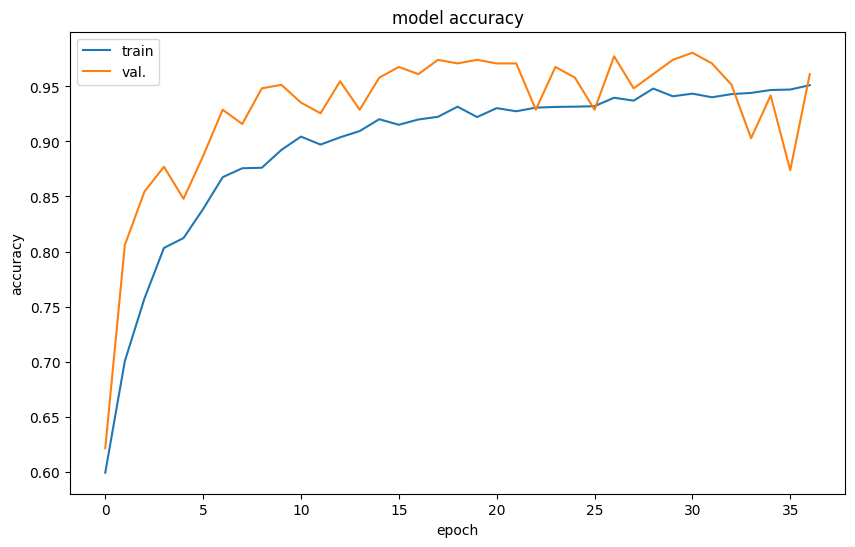

In [12]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 6

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='upper left')
plt.show()

29/29 [==============================] - 0s 5ms/step
Confusion Matrix
[[138   4   0   0]
 [ 14 124   5   8]
 [  0   4 480  30]
 [  0   0   0 113]]
Classification Report
              precision    recall  f1-score   support

    Cellular       0.91      0.97      0.94       142
  Mixed Mode       0.94      0.82      0.88       151
      Linear       0.99      0.93      0.96       514
       Other       0.75      1.00      0.86       113

    accuracy                           0.93       920
   macro avg       0.90      0.93      0.91       920
weighted avg       0.94      0.93      0.93       920



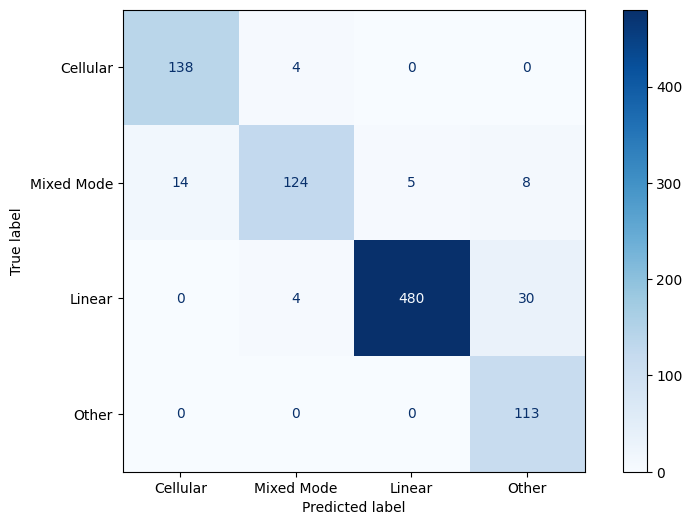

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

print('Confusion Matrix')
print(confusion_matrix(y_test_, y_pred))
print('Classification Report')
target_names = ['Cellular', 'Mixed Mode', 'Linear', 'Other']
print(classification_report(y_test_, y_pred, target_names=target_names))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_, y_pred), display_labels=target_names)
disp.plot(cmap='Blues')

In [14]:
#save the model
model.save("/share/jcorner_data/models/future_modes_v3.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
